# Notebook 1: Prepare TDE-PCA data

In this notebook, we will cover:
1. **Data loading**: How to load data with the osl_dynamics `Data` API.
2. **Data preparation**: How to prepare data for training.
3. **Saving prepared data**: How to save prepared data for later use.

## 1. Data loading

We can first find the `.fif` files we have downloaded. A good way to find matching files is to use the `glob` library and use `sorted` to sort the filenames alphabetically.

In [1]:
from glob import glob
from pprint import pprint

files = sorted(glob("wakeman-henson/*/*_sflip_lcmv-parc-raw.fif"))
pprint(files)

['wakeman-henson/sub-01_run-01/sub-01_run-01_sflip_lcmv-parc-raw.fif',
 'wakeman-henson/sub-02_run-01/sub-02_run-01_sflip_lcmv-parc-raw.fif',
 'wakeman-henson/sub-03_run-01/sub-03_run-01_sflip_lcmv-parc-raw.fif',
 'wakeman-henson/sub-04_run-01/sub-04_run-01_sflip_lcmv-parc-raw.fif',
 'wakeman-henson/sub-05_run-01/sub-05_run-01_sflip_lcmv-parc-raw.fif']


You should see 5 filenames being printed. If you find that an empty list is printed, it is because the data files have not been downloaded. Please check out the `0_get_data.ipynb` notebook and download the data.

Next we will load the data using the `Data` API in `osl_dynamics`. The `Data` API is a convenient way to load data and prepare it for training. It will automatically handle the loading of the data, the splitting into training and test sets if you need, and the pipeline for creating TensorFlow Datasets. You can check the [documentation](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/data/base/index.html#osl_dynamics.data.base.Data) for more details on the `Data` API.

In [2]:
from osl_dynamics.data import Data
data = Data(files, picks="misc", reject_by_annotation="omit")

Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

Notice that we have used `picks="misc"` to only select the `misc` channels. This is because there are additional channels correponding to stimuli that are not needed for the training. We have also used `reject_by_annotation="omit"` to remove bad segments labelled during data preprocessing. We can have a look at the summary of the `Data` object by directly printing it.

In [3]:
print(data)

Data
 id: 6008370960
 n_sessions: 5
 n_samples: 599252
 n_channels: 38


You can get access to the numpy arrays of the original time series data by calling the `data.time_series()` method.

In [4]:
for x in data.time_series():
    print(x.shape)

(122001, 38)
(118750, 38)
(116501, 38)
(121000, 38)
(121000, 38)


In the above we used the `Data` API to load `.fif` files. But the API can also load data in other formats. Data can be loaded from:
- `.fif` files
- `.mat` files
- `.npy` files
- path to a directory containing files with the above extensions

See the [online tutorial](https://osl-dynamics.readthedocs.io/en/latest/tutorials_build/data_loading.html) for more details.

## 2. Data preparation
Now we move on to preparing the data for training. We will use *Time Delayed Embedding* (TDE) to include spectral information into the data and use *Principle Component Analysis* (PCA) to reduce the dimensionality of the data. The `Data` API comes with a convenient method to do all this:

In [5]:
data.tde_pca(n_embeddings=15, n_pca_components=80)

Calculating PCA components:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-16 16:41:38 INFO osl-dynamics [base.py:852:tde_pca]: Explained variance: 69.0%


TDE-PCA:   0%|          | 0/5 [00:00<?, ?it/s]

We have used `n_embeddings=15` to add `±7` lagged versions of the data as extra channels and `n_components=80` to reduce the dimensionality of the data to 80 components.

A rough rule of thumb is to use higher `n_embeddings` for data with higher sampling frequency. The following combinations have been found to work well and are a good starting point:
- 100 Hz: `n_embeddings=7`, `n_components=2 * data.n_channels`
- 250 Hz: `n_embeddings=15`, `n_components=2 * data.n_channels`

For more details on the effect of `n_embeddings`, check out the [online tutorial](https://osl-dynamics.readthedocs.io/en/latest/tutorials_build/data_time_delay_embedding.html) where you can try out different values for `n_embeddings` to see how it affects the data.

Next we will standardise (z-transform) the data for training. This is a common practice and is done to make sure that the data is centred and has unit variance. This is important for stability and convergence of model training.

Please note that the standardisation is done for each channel and each session separately.

In [6]:
data.standardize()

Standardize:   0%|          | 0/5 [00:00<?, ?it/s]

Notice some preparation methods change the number of time points, in particular after TDE, `n_embeddings // 2` time points are removed from the beginning and the end of the time series. We can see this by printing the shape of the data now:

In [7]:
for x in data.time_series():
    print(x.shape)

(121987, 80)
(118736, 80)
(116487, 80)
(120986, 80)
(120986, 80)


We can still get access to the original time series data before preparation by setting `prepared=False` in the `data.time_series()` method.:

In [8]:
for x in data.time_series(prepared=False):
    print(x.shape)

(122001, 38)
(118750, 38)
(116501, 38)
(121000, 38)
(121000, 38)


### Further notes on data preparation

The above steps for preparing data can also be chained together and done with the `Data.prepare()` method. This is a convenient way to specify the entire pipeline for preparing the data.

```python
data.prepare({
        "tde_pca": {"n_embeddings": 15, "n_components": 80},
        "standardize": {},
})
```
Other methods for preparing the data are also available. These include and are not limited to:
- Select channels: `Data.select()`
- Butterworth filter: `Data.filter()`
- Downsample: `Data.downsample()`
- Principal component analysis (PCA): `Data.pca()`
- Time-delay embedding (TDE): `Data.tde()`
- PCA-TDE: `Data.pca_tde()`
- Amplitude envelope: `Data.amplitude_envelope()`
- Moving average: `Data.moving_average()`
- Standardise (z-transform): `Data.standardize()`
- Dipole sign flipping: `Data.align_channel_signs()`
- Remove bad segments: `Data.remove_bad_segments()`

See [API reference](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/data/base/index.html#osl_dynamics.data.base.Data) for details on arguments and options for each method.

## 3. Saving prepared data
Finally we can save our prepared data to disk for later use.

In [9]:
data.save("prepared_data")

Saving data:   0%|          | 0/5 [00:00<?, ?it/s]

## Parallelise data preparation
The `Data` API also supports parallelisation of data preparation. This is done by using the `n_jobs` argument when creating the `Data` object.

```python
data = Data(files, picks="misc", reject_by_annotation="omit", n_jobs=4)
```
This will use 4 CPU cores to load and prepare the data, which can significantly speed up the process especially for datasets with large number of sessions.

## Exercise
Try to prepare the data with amplitude envelope and moving average.

Solutions shown below.

Solutions shown below.

Solutions shown below.

## Solution

In [10]:
data.prepare({
        "amplitude_envelope": {"use_raw": True},
        "moving_average": {"n_window": 5},
})

Amplitude envelope:   0%|          | 0/5 [00:00<?, ?it/s]

Sliding window:   0%|          | 0/5 [00:00<?, ?it/s]

We can check the effect by plotting the amplitude envelope data and the original data of channel 0 of the first session.

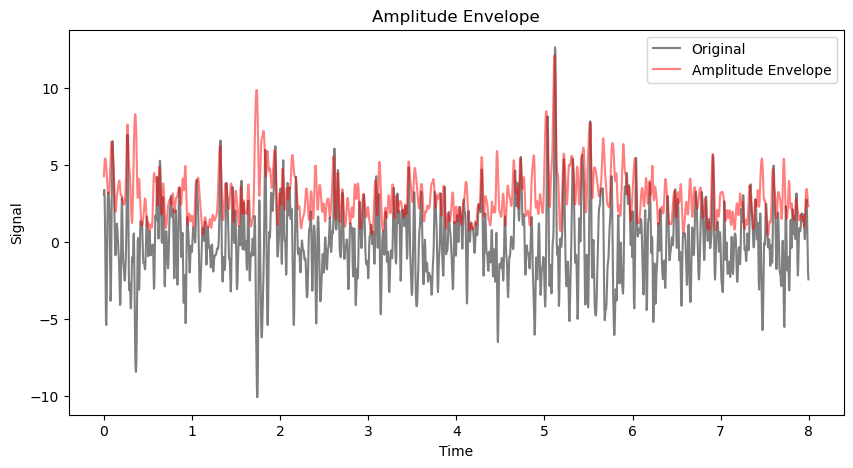

In [11]:
from matplotlib import pyplot as plt
import numpy as np

def plot_ae(data, n_samples):
    timestamps = np.arange(n_samples) / 250
    original_x = data.time_series(prepared=False)[0][:n_samples]
    ae_x = data.time_series()[0][:n_samples]

    plt.figure(figsize=(10, 5))
    plt.plot(timestamps, original_x[:, 0], label="Original", color="black", alpha=0.5)
    plt.plot(timestamps, ae_x[:, 0], label="Amplitude Envelope", color="red", alpha=0.5)
    plt.title("Amplitude Envelope")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()

plot_ae(data, n_samples=2000)